In [ ]:
import os
import pandas as pd
import ibm_boto3
from ibm_botocore.client import Config
import types
import joblib
from project_lib import Project
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from ibm_watson_machine_learning import APIClient
from dotenv import load_dotenv

load_dotenv()

COS_API_KEY_ID = os.getenv('COS_API_KEY_ID')
COS_SERVICE_INSTANCE_ID = os.getenv('COS_SERVICE_INSTANCE_ID')
BUCKET_NAME = os.getenv('BUCKET_NAME')
WML_API_KEY = os.getenv('WML_API_KEY')

print("Environment variables set successfully.")

COS_API_KEY_ID = os.environ.get("COS_API_KEY_ID")
COS_SERVICE_INSTANCE_ID = os.environ.get("COS_SERVICE_INSTANCE_ID")
BUCKET_NAME = os.environ.get("BUCKET_NAME")
COS_ENDPOINT = "https://s3.us-south.cloud-object-storage.appdomain.cloud"

Cloud_Object_Storage_rx_client = ibm_boto3.client(
    service_name='s3',
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_SERVICE_INSTANCE_ID,
    ibm_auth_endpoint='https://iam.cloud.ibm.com/identity/token',
    config=Config(signature_version='oauth'),
    endpoint_url=COS_ENDPOINT
)

bucket = BUCKET_NAME
object_key = 'raw_water_potability_data.csv'

def __iter__(self): return 0

body = Cloud_Object_Storage_rx_client.get_object(Bucket=bucket, Key=object_key)['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df = pd.read_csv(body)

print("Data successfully loaded into a DataFrame.")

df_cleaned = df.dropna()
X = df_cleaned.drop('Potability', axis=1)
y = df_cleaned['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("\nModel training complete.")

wml_credentials = {
    "apikey": os.environ.get("WML_API_KEY"),
    "url": "https://us-south.ml.cloud.ibm.com"
}
wml_client = APIClient(wml_credentials)
space_id = "da932741-b9f8-4c68-af1e-87f86660310a"
wml_client.set.default_space(space_id)

software_spec_name = 'runtime-24.1-py3.11'
software_spec_uid = wml_client.software_specifications.get_uid_by_name(software_spec_name)

model_props = {
    wml_client.repository.ModelMetaNames.NAME: 'Water Potability Random Forest Model',
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.3', # Correcting the model type
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

published_model = wml_client.repository.store_model(
    model=model,
    meta_props=model_props
)

print("Model successfully stored in Watson Machine Learning repository.")

Environment variables set successfully.
Data successfully loaded into a DataFrame.

Model training complete.
Model successfully stored in Watson Machine Learning repository.


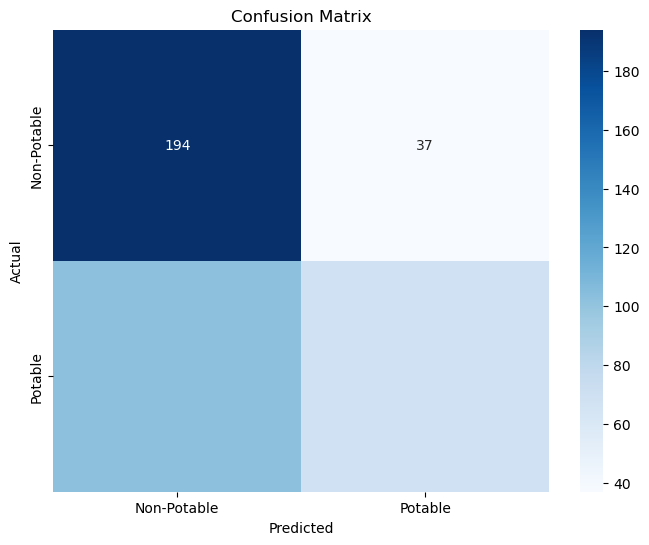


Classification Report:
              precision    recall  f1-score   support

 Non-Potable       0.65      0.84      0.73       231
     Potable       0.65      0.40      0.50       172

    accuracy                           0.65       403
   macro avg       0.65      0.62      0.62       403
weighted avg       0.65      0.65      0.63       403



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Potable', 'Potable'],
            yticklabels=['Non-Potable', 'Potable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Potable', 'Potable']))